In [2]:
# External dependencies
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import timedelta
from datetime import datetime as dt

# Constants
TRADING_DAYS: int = 10
VOL_TARGET: float = 0.20
TRADING_HOURS_PER_DAY: int = 7
TRADING_30_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 2
TRADING_5_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 12

Load Data

In [142]:
daily = yf.download(tickers="SPY", interval="1d")["Close"].pct_change()
hourly = yf.download(tickers="SPY", start=dt.today().date() + timedelta(days=-365), interval="1h")["Close"].pct_change()
min_30 = yf.download(tickers="SPY", start=dt.today().date() + timedelta(days=-30), interval="30m")["Close"].pct_change()
min_5 = yf.download(tickers="SPY", start=dt.today().date() + timedelta(days=-30), interval="5m")["Close"].pct_change()

returns = pd.concat(
    [
        daily,
        hourly,
        min_30,
        min_5
    ],
    axis=1
)
returns.columns = ["1d", "1h", "30m", "5m"]
returns

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,1d,1h,30m,5m
1993-01-29 00:00:00+00:00,NaN,NaN,NaN,NaN
1993-02-01 00:00:00+00:00,0.007112,NaN,NaN,NaN
1993-02-02 00:00:00+00:00,0.002119,NaN,NaN,NaN
1993-02-03 00:00:00+00:00,0.010571,NaN,NaN,NaN
1993-02-04 00:00:00+00:00,0.004184,NaN,NaN,NaN
...,...,...,...,...
2024-12-20 14:50:00+00:00,NaN,NaN,NaN,0.001239
2024-12-20 14:55:00+00:00,NaN,NaN,NaN,-0.000584
2024-12-20 15:00:00+00:00,NaN,NaN,NaN,0.001847
2024-12-20 15:05:00+00:00,NaN,NaN,NaN,-0.000641


Build Exponentially Weighted Risk Model

In [143]:
risk_model = pd.concat(
    [
        (returns["1d"].dropna().ewm(halflife=TRADING_DAYS / 2).std().dropna() * np.sqrt(252)).tail(20),
        (returns["1h"].dropna().ewm(halflife=TRADING_DAYS * TRADING_HOURS_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_HOURS_PER_DAY * 252)).tail(20 * TRADING_HOURS_PER_DAY),
        (returns["30m"].dropna().ewm(halflife=TRADING_DAYS * TRADING_30_MIN_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_30_MIN_PER_DAY * 252)).tail(20 * TRADING_30_MIN_PER_DAY),
        (returns["5m"].dropna().ewm(halflife=TRADING_DAYS * TRADING_5_MIN_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_5_MIN_PER_DAY * 252)).tail(20 * TRADING_5_MIN_PER_DAY)
    ],
    axis=1
).ffill()
risk_model.columns = ["1d", "1h", "30m", "5m"]
risk_model["mean"] = risk_model.mean(axis=1)
risk_model["mean"].iloc[-1].round(4)

0.1459

Plot Ex Ante Risk

<Axes: title={'center': 'Ex Ante Volatility'}>

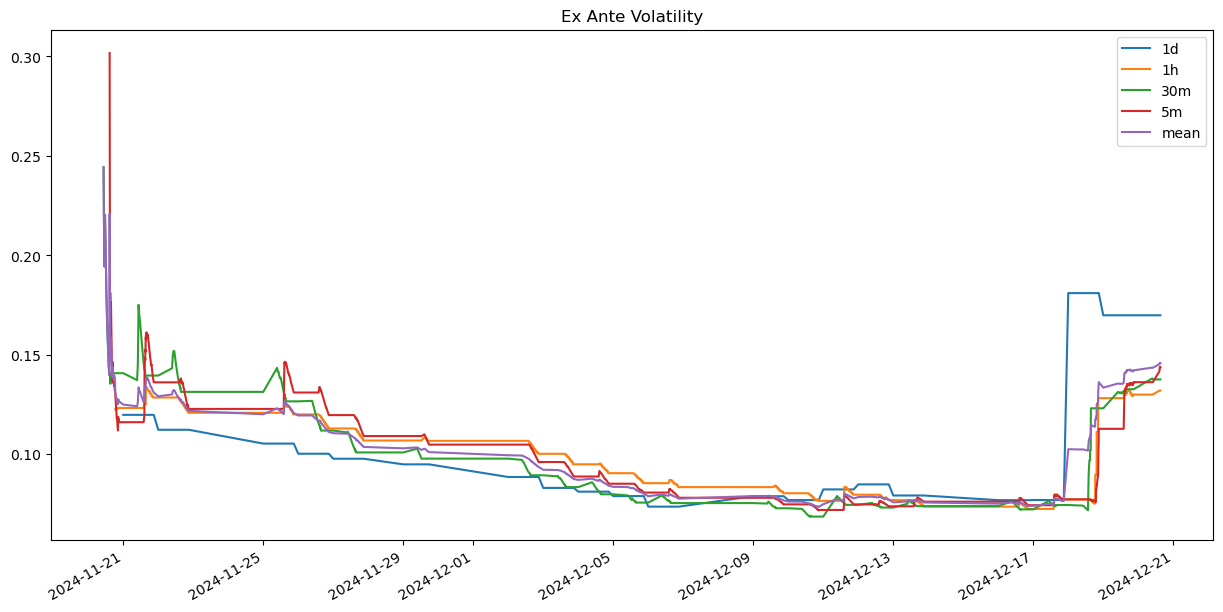

In [144]:
risk_model.plot(title="Ex Ante Volatility", figsize=(15, 7.5))

In [145]:
leverage_target = VOL_TARGET / risk_model["mean"].iloc[-1].round(4)
leverage_target

1.3708019191226868

In [146]:
2 * risk_model["mean"].iloc[-1].round(4)

0.2918

In [1]:
import yfinance as yf

In [3]:
data = yf.download(tickers="TLT", period="max")
data["adj_close_returns"] = data["Adj Close"].pct_change()
data["adj_close_returns"].mean() / data["adj_close_returns"].std() * np.sqrt(252)

[*********************100%***********************]  1 of 1 completed


0.3303854967473725

<Axes: xlabel='Date'>

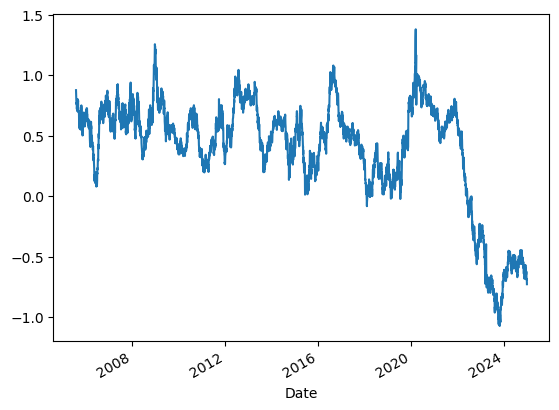

In [4]:
(data["adj_close_returns"].rolling(252 * 3).mean() / data["adj_close_returns"].rolling(252 * 3).std() * np.sqrt(252)).plot()

<Axes: xlabel='Date'>

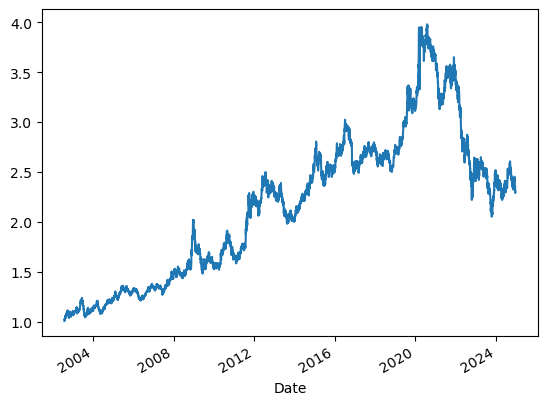

In [5]:
(1 + data["adj_close_returns"]).cumprod().plot()

In [6]:
data["adj_close_returns"].std() * np.sqrt(252)

0.14482747124653073

In [7]:
spy = yf.download(tickers="UPRO")
spy["adj_close_returns"] = spy["Adj Close"].pct_change()


[*********************100%***********************]  1 of 1 completed


In [8]:
x = pd.concat([spy["adj_close_returns"], data["adj_close_returns"]], axis=1).dropna()
x.columns = ["SPY", "TLT"]
x = x.loc["20101231":]
x

,SPY,TLT
Date,,
2010-12-31 00:00:00+00:00,0.000488,0.011065
2011-01-03 00:00:00+00:00,0.029086,-0.007544
2011-01-04 00:00:00+00:00,-0.003130,0.001177
2011-01-05 00:00:00+00:00,0.016936,-0.022028
2011-01-06 00:00:00+00:00,-0.005894,0.004374
...,...,...
2024-12-16 00:00:00+00:00,0.012005,0.002995
2024-12-17 00:00:00+00:00,-0.012775,0.002433
2024-12-18 00:00:00+00:00,-0.088631,-0.012504


In [10]:
# w = np.array([[0.3 * 3], [0.7]])
w = np.array([[0.5], [0.5]])

In [12]:
rets = (x * w.T).sum(axis=1)
rets

Date
2010-12-31 00:00:00+00:00    0.005777
2011-01-03 00:00:00+00:00    0.010771
2011-01-04 00:00:00+00:00   -0.000977
2011-01-05 00:00:00+00:00   -0.002546
2011-01-06 00:00:00+00:00   -0.000760
                               ...   
2024-12-16 00:00:00+00:00    0.007500
2024-12-17 00:00:00+00:00   -0.005171
2024-12-18 00:00:00+00:00   -0.050568
2024-12-19 00:00:00+00:00   -0.008698
2024-12-20 00:00:00+00:00    0.019450
Length: 3517, dtype: float64

In [15]:
x.mean() / x.std() * np.sqrt(252), x.std() * np.sqrt(252)

(SPY    0.753087
 TLT    0.227705
 dtype: float64,
 SPY    0.511535
 TLT    0.152326
 dtype: float64)

In [17]:
rets.mean() / rets.std() * np.sqrt(252)

0.8621562203246699

In [18]:
rets.std() * np.sqrt(252)

0.2435262421221535

<Axes: xlabel='Date'>

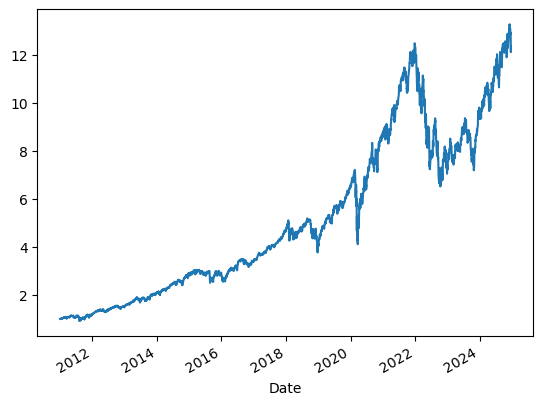

In [19]:
(1 + rets).cumprod().plot()

<Axes: xlabel='Date'>

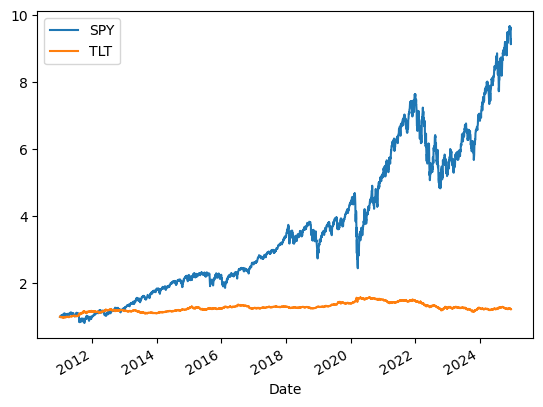

In [20]:
(1 + x / 3 * 1.5).cumprod().plot()

<Axes: xlabel='Date'>

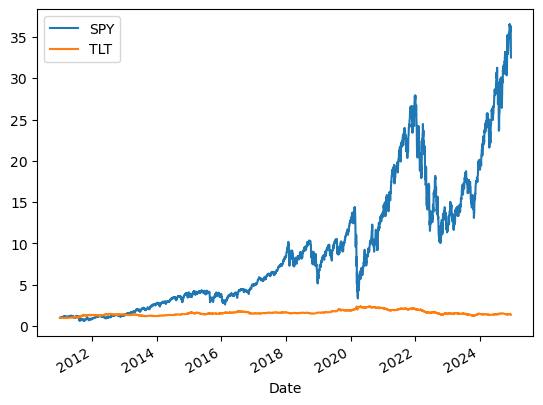

In [366]:
(1 + x).cumprod().plot()